In [9]:
from surface_dynamics.all import Origami

In [10]:
# The matrices S, S^(-1), and R generate the group SL2Z
S = Matrix(ZZ, [[1,1],[0,1]])
R = Matrix(ZZ,[[0,-1],[1,0]])

# The SL2Z_Action function takes an origami ori and a 2x2 matrix A with integer coefficients as arguments
# It tests whether A is an element of SL2Z, and if so it returns the image of ori under the action of A
# If A is not an element of SL2Z, it returns an error message
def SL2Z_Action(ori, A):
    
    # Tests whether A is in SL2Z
    if det(A) != 1:
        return "Error: The input matrix is not an element of SL2Z"
        
    # List that will hold generators that produce A when multiplied in the order they appear
    # Temporary matrix that we will update as we reduce A to the identity using generators
    generators = []
    A_temp = A
    
    # Reduce A_temp to the identity by multiplying on the left by S, S^(-1), and R repeatedly
    # Simultaneously add the inverse of the matrix that is being multiplied to the end of list of generators
    while A_temp[1][0] != 0:
        if abs(A_temp[0][0])>=abs(A_temp[1][0]):
            if sgn(A_temp[0][0]) == sgn(A_temp[1][0]):
                A_temp = S^(-1)*A_temp
                generators = generators + [S]
            else:
                A_temp = S*A_temp
                generators = generators + [S^(-1)]
        else:
            A_temp = R*A_temp
            generators = generators + [R,R,R]
    if A_temp[0][0] == 1:
        while A_temp[0][1] > 0:
            A_temp = S^(-1)*A_temp
            generators = generators + [S]
        while A_temp[0][1] < 0:
            A_temp = S*A_temp
            generators = generators + [S^(-1)]
    else:
        while A_temp[0][1] < 0:
            A_temp = S^(-1)*A_temp
            generators = generators + [S]
        while A_temp[0][1] > 0:
            A_temp = S*A_temp
            generators = generators + [S^(-1)]
        A_temp = R*R*A_temp
        generators = generators + [R,R]
    
    # Test to confirm that generators in list multiply to produce A
    # If not, return error message
    product = Matrix(ZZ,[[1,0],[0,1]])
    for generator in generators:
        product = product*generator
    if product != A:
        return "Error: Decomposition into product of generators has failed"
        
    # Origami that will be returned after the action of A is applied
    A_times_ori = ori
    
    # Apply generators in list in reverse order because A is multiplied on the left of ori
    for generator in reversed(generators):
        if generator == R:
            A_times_ori = A_times_ori.horizontal_symmetry().mirror()
            # print('R')
        elif generator == S:
            A_times_ori = A_times_ori.horizontal_twist(1)
            # print('S')
        else:
            A_times_ori = A_times_ori.horizontal_twist(-1)
            # print('S_inv')
            
    return A_times_ori

In [11]:
# The find_Simple_Cylinder function takes as its input an origami ori_0. It searches the whole SL2Z orbit of ori_0
# for all horizontal simple cylinders. Every simple cylinder in ori_0 will be represented at least once in the output.
# It returns a list of tuples, where each tuple is of the form
# (A^(-1),ori,cyl_rows,height,width,twist,bot_sing,top_sing), where:
# * A^(-1) is the matrix in SL2Z that maps ori_0 to the origami where this simple cylinder was found
# * ori is the output of the action of A^(-1) on ori_0
# * cyl_rows is a list of tuples, where each tuple represents a row of the simple cylinder and the rows are stacked in the order
# they appear in the list, with the first row in the list at the bottom of the corresponding simple cylinder
# * height is the height of the simple cylinder
# * width is the width of the simple cylinder
# * twist of the horizontal distance (travelling to the right) from the bottom singularity to the top singularity
# * bot_sing is the square in the simple cylinder that has a singularity on its bottom right corner
# * top_sing is the square in the simple cylinder that has a singularity on its top right corner
def find_Simple_Cylinder(ori_0):
    simple_cylinders = []
    
    # Loops over the SL2Z orbit of ori_0
    for A in ori_0.veech_group().coset_reps():
        ori = SL2Z_Action(ori_0, A^(-1)) # Use A^(-1) because coset_reps() gives right coset reps
        cylinders = ori.r().cycle_tuples(singletons=True)
        
        # Loops over all horizontal cycles of ori
        for cylinder in cylinders:
            top_sings = [] # List of squares with singular points in their top right corner
            cyl_rows = [cylinder] # List of rows in the smallest cylinder containing starting row and at least one singularity on top and bottom
            while len(top_sings) == 0 and len(cyl_rows) < len(cylinders):
                for i in cyl_rows[-1]:
                    if ori.r()(ori.u()(i)) != ori.u()(ori.r()(i)):
                        top_sings.append(i) # Counts number of singularities above top row of cyl_rows
                
                if len(top_sings) == 0:
                    above_row = []
                    for i in cyl_rows[-1]:
                        above_row.append(ori.u()(i))
                    cyl_rows.append(tuple(above_row)) # Adds another row above if there are no singular points yet
            if len(top_sings) == 1:
                bot_sings = [] # List of squares with singular points in their bottom right corner
                while len(bot_sings) == 0 and len(cyl_rows) < len(cylinders):
                    for i in cyl_rows[0]:
                        if ori.r()(ori.u().inverse()(i)) != ori.u().inverse()(ori.r()(i)):
                            bot_sings.append(i) # Counts number of singularities below bottom row of cyl_rows
                            
                    if len(bot_sings) == 0:
                        below_row = []
                        for i in cyl_rows[0]:
                            below_row.append(ori.u().inverse()(i))
                        cyl_rows.insert(0,tuple(below_row)) # Adds another row below if there are no singular points yet
                
                # If there is exactly one singular point on bottom and top, creates cylinder tuple and adds it to list if not yet included
                if len(bot_sings) == 1:
                    top_sing = top_sings[0]
                    bot_sing = bot_sings[0]
                    height = len(cyl_rows)
                    width = len(cyl_rows[0])
                    twist = 0
                    bot_sing_im = bot_sing
                    for i in range(1,height):
                        bot_sing_im = ori.u()(bot_sing_im) # bot_sing_im is image of bottom singularity on the top row of the cylinder
                    while bot_sing_im != top_sing:
                        bot_sing_im = ori.r()(bot_sing_im)
                        twist = twist+1
                    cyl_info = (A^(-1),ori,cyl_rows,height,width,twist,bot_sing,top_sing)
                    
                    if cyl_info not in simple_cylinders:
                        simple_cylinders.append(cyl_info)
                        
    return simple_cylinders

In [15]:
ori = Origami('(1,2,3)(4,5,6,7,8)(9,10,11)','(1,5,9)(2,6,10)(3,7,11)')
#ori.show()
print(ori.stratum())
for tup in find_Simple_Cylinder(ori):
    print(tup, '\n')

H_2(2)
([1 0]
[0 1], (1,2,3)(4,5,6,7,8)(9,10,11)
(1,5,9)(2,6,10)(3,7,11)(4)(8), [(9, 10, 11), (1, 2, 3)], 2, 3, 0, 11, 3) 

([-1 10]
[-6 59], (1)(2)(3)(4,8,7)(5)(6)(9)(10)(11)
(1,11,7,2,9,5,3,10,6)(4)(8), [(2,), (9,), (5,), (3,), (10,), (6,), (1,), (11,)], 8, 1, 0, 2, 11) 

([  5 -49]
[ -6  59], (1)(2)(3)(4,8,5)(6)(7)(9)(10)(11)
(1,11,6,2,9,7,3,10,5,4,8), [(1,), (11,), (6,), (2,), (9,), (7,), (3,), (10,)], 8, 1, 0, 1, 10) 

([-7 69]
[-6 59], (1)(2)(3)(4,8,7)(5)(6)(9)(10)(11)
(1,11,7,8,4,2,9,5,3,10,6), [(2,), (9,), (5,), (3,), (10,), (6,), (1,), (11,)], 8, 1, 0, 2, 11) 

([-128 1261]
[-485 4778], (1)(2)(3,11)(4)(5,6)(7)(8)(9)(10)
(1,9,7,4,2,10,8,5,11,6,3), [(1,), (9,), (7,), (4,), (2,), (10,), (8,)], 7, 1, 0, 1, 8) 

([  182 -1793]
[ -209  2059], (1,5,4,3,2)(6)(7)(8)(9)(10)(11)
(1)(2)(3)(4)(5,6,7,8,11,9,10), [(6,), (7,), (8,), (11,), (9,), (10,)], 6, 1, 0, 6, 10) 

([  391 -3852]
[ -209  2059], (1,5,4,3,2)(6)(7)(8)(9)(10)(11)
(1,6,7,8,11,9,10,5,4,3,2), [(6,), (7,), (8,), (11,), (9,), (1

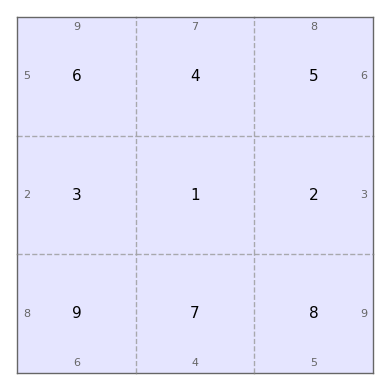

H_1(0)
[]


In [16]:
ori = Origami('(1,2,3)(4,5,6)(7,8,9)','(1,4,7)(2,5,8)(3,6,9)')
ori.show()
print(ori.stratum())
print(find_Simple_Cylinder(ori))

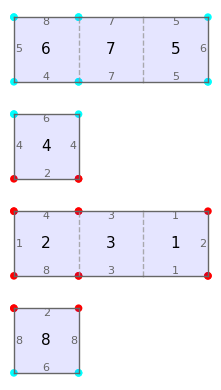

H_3(2^2)
[([1 0]
[0 1], (1,2,3)(4)(5,6,7)(8)
(1)(2,4,6,8)(3)(5)(7), [(4,)], 1, 1, 0, 4, 4), ([1 0]
[0 1], (1,2,3)(4)(5,6,7)(8)
(1)(2,4,6,8)(3)(5)(7), [(8,)], 1, 1, 0, 8, 8), ([  62 -107]
[ -73  126], (1,4,5,8)(2)(3)(6)(7)
(1)(2,8,7)(3,6,4)(5), [(7,), (2,)], 2, 1, 0, 7, 2), ([  62 -107]
[ -73  126], (1,4,5,8)(2)(3)(6)(7)
(1)(2,8,7)(3,6,4)(5), [(3,), (6,)], 2, 1, 0, 3, 6), ([ 135 -233]
[ -73  126], (1,4,5,8)(2)(3)(6)(7)
(1,3,6,4,5,7,2,8), [(7,), (2,)], 2, 1, 0, 7, 2), ([ 135 -233]
[ -73  126], (1,4,5,8)(2)(3)(6)(7)
(1,3,6,4,5,7,2,8), [(3,), (6,)], 2, 1, 0, 3, 6), ([-11  19]
[-73 126], (1)(2)(3,4,7,8)(5)(6)
(1,7,4,2,5,3,8,6), [(6,), (1,)], 2, 1, 0, 6, 1), ([-11  19]
[-73 126], (1)(2)(3,4,7,8)(5)(6)
(1,7,4,2,5,3,8,6), [(2,), (5,)], 2, 1, 0, 2, 5), ([ 208 -359]
[ -73  126], (1,4,5,8)(2)(3)(6)(7)
(1,5)(2,8,3,6,4,7), [(7,), (2,)], 2, 1, 0, 7, 2), ([ 208 -359]
[ -73  126], (1,4,5,8)(2)(3)(6)(7)
(1,5)(2,8,3,6,4,7), [(3,), (6,)], 2, 1, 0, 3, 6), ([ 1 -1]
[ 0  1], (1,2,3)(4)(5,6,7)(8)
(1,4,6,7,5,

In [17]:
ori = Origami('(1,2,3)(5,6,7)','(2,4,6,8)')
ori.show()
print(ori.stratum())
print(find_Simple_Cylinder(ori))